Here we propose the way of comparing the local volatility model with stochastic volatility. The setup is the following: 

1. We assume that the option prices are given by the Heston model. To generate option prices we use COS method (see *Fang, Fang and Cornelis W. Oosterlee. “A Novel Pricing Method for European Options Based on Fourier-Cosine Series Expansions.” SIAM J. Sci. Comput. 31 (2008): 826-848.*). 


2. For a given set of generated option prices we calculate local voaltility using Dupire's formula. 


3. Then, we simulate asset paths using local volatility model. In addition, we calculate implied volatilites from LV model and generated by Heston option ptices. 

In [1]:
from COSMethod1D import *
from tqdm.auto import tqdm, trange
from dataclasses import dataclass, field
from scipy.interpolate import interp1d, RectBivariateSpline

In [2]:
@dataclass()
class PMParameters:
    n_particles: int
    n_steps: int
    kernel_threshold: float = .95
    kernel_scaling_factor: float = 1.5
    kernel_t_min: float = .25
    grid_range_proba: float = 1e-3
    n_interp: int = 50
    
    """Class for storing particle method parameters
    
    Fields:
        n_particles (int): number of particles.
        n_steps (int): number of discretization steps in Euler's scheme.
        kernel_threshold (float): the particle method requires computation
            of the expectation condidtioned on the spot being equal to some value.
            The points with the kernel value more than kernel_threshold for
            the spot value are used to approximate conditional expectation.
        kernel_scaling_factor (float): quadratic kernel is used for computing
            the conditional expectation of variace process. Complex scaling
            is used for each point with tunable kernel_scaling_factor. 
            \kappa in 11.6.2 in Nonlinear Option Pricing by Guyon, Labordere.
        kernel_t_min (float): see 11.6.2 in Nonlinear Option Pricing by Guyon, Labordere.
        grid_range_proba (float): the interpolation grid for the leverage 
            function range will be determined using quantiles of this order.
        n_interp (int): number of points for the leverage fuction interpolation
            at each time step.
    """

In [3]:
def cir_chi_sq_sample(heston_params: HestonParameters,
                      dt: float,
                      v_i: np.array,
                      n_simulations: int):
    """Samples chi_sqqred statistics for v_{i+1} conditional on 
       v_i and parameters of Hestom model. 
        
    Args:
        heston_params (HestonParameters): parameters of Heston model
        dt (float): time step 
        v_i: current volatility value
        n_simulations (int): number of simulations.
        
    Returns:
        np.array: sampled chi_squared statistics 
    """
    kappa, vbar, gamma = heston_params.kappa, heston_params.vbar, heston_params.gamma
    
    # YOUR COED HERE:
    # calculate \delta, c and \bar \kappa from Heston parameters and sample the value from
    # noncentral chi square distribution.
    # Hint 1: 
    #     Use np.random.noncentral_chisquare(...)
    #--------------------------------------------

    delta = 4.0 * kappa*vbar / (gamma **2)
    c = 1.0 / (4.0 * kappa) * gamma**2 * (1.0 - np.exp(-kappa * dt))
    kappaBar = 4.0 * kappa * v_i * np.exp(-kappa * dt) / ((gamma ** 2) * (1.0 - np.exp(- kappa * dt)))
    sample = c * np.random.noncentral_chisquare(delta, kappaBar, n_simulations)
    
    #--------------------------------------------
    
    return  sample

In [4]:
def simulate_paths_heston_andersen(time: Union[float, np.ndarray],
                                   n_simulations: int,
                                   state: MarketState,
                                   heston_params: HestonParameters) -> dict:
    """Simulates price and volatility process evaluating it at given time points 
       using Andersen scheme. 
        
    Args:
        time (float or np.darray): time point(s) at which the price shoud be evaluated.
        n_simulations (int): number of simulations.
        state (MarketState): initial market state to start from.
        heston_params (HestonParameters): parameters of Heston model.
        
    Returns:
        dict: simulated asset and volatility paths
    """
    
    # initialize market and model parameters
    r, s0 = state.interest_rate,  state.stock_price
    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, heston_params.vbar, heston_params.gamma
    
    # initialize noise array
    Z1 = np.random.normal(size=(n_simulations, np.shape(time)[0]))
    
    # initialize zero array for volatility values
    V = np.zeros([n_simulations, np.shape(time)[0]])
    V[:, 0] = v0
    
    # initialize zero array for log price values
    logS = np.zeros([n_simulations, np.shape(time)[0]])
    logS[:, 0] = np.log(s0)
    
    # YOUR CODE HERE
    # Hint 1:
    #     You need to iterate in time and calculate logS[:, ind + 1] and V[:,ind + 1] given 
    #     logS[:, ind] and V[:, ind]. Notice that the V[:, ind] values may be negative, so you 
    #     may reflect the the positively or truncate it (take (max(V[:, ind], 0)).
    #
    # Hint 2: 
    #     You may use cycles if you wish. However, it is possible 
    #     to code it in a vectorized form.
    # Hint 3:
    #     In order to get chi^2 sample, just call the cir_chi_sq_sample(...) function.
    #----------------------------------------------------------------------------------------
    
    for ind in range(np.shape(time)[0] - 1):
        dt = time[ind + 1] - time[ind]
        
        V[:,ind + 1] = cir_chi_sq_sample(heston_params, dt, V[:, ind], n_simulations)
        
        V[:,ind + 1] = np.maximum(V[:, ind + 1], 0.0)
        
        logS[:, ind + 1] = logS[:, ind] + (r - V[:, ind] / 2) * dt + \
                           (rho / gamma) * (V[:, ind + 1] - V[:, ind] - kappa * (vbar - V[:, ind]) * dt) + \
                           np.power((1 - rho**2) * dt * V[:, ind], 0.5) * Z1[:, ind] 
    #----------------------------------------------------------------------------------------
    
    simulated_paths = {"asset": np.exp(logS), "volatility": V}
    
    return simulated_paths

In [63]:
def make_local_vol_func(calls: CallStockOption,
                        call_prices: np.ndarray,
                        interest_rate: float = 0) -> Callable[[float, float], float]:
    """Returns local volatility function given market call prices
    
    Args:
        calls (CallStockOption): an object of type CallStockOption.
            The attributes are the points at which market call prices are observed.
        call_prices (np.ndarray): matrix of call prices evaluated at given points.
            The dimensions are (time, strikes).
        interest_rate (float): the risk-free rate.
        
    Returns:
        function that evaluates local volatility (not variance!) at given point
    """
    
    dcdt, dcdk = np.gradient(call_prices, calls.expiration_time, calls.strike_price)
    _, d2cdk2 = np.gradient(dcdk, calls.expiration_time, calls.strike_price)
    T, K = np.meshgrid(calls.expiration_time, calls.strike_price, indexing='ij')
    lv = np.sqrt(np.maximum((dcdt + interest_rate * K * dcdk) / (0.5 * K ** 2 * d2cdk2), np.finfo(np.float64).eps))
    
    calls_int = RectBivariateSpline(calls.expiration_time,
                                    calls.strike_price,
                                    lv)
    
    def local_vol_func(t, s):
        
        return calls_int(t, s, grid=False)
    
    return local_vol_func

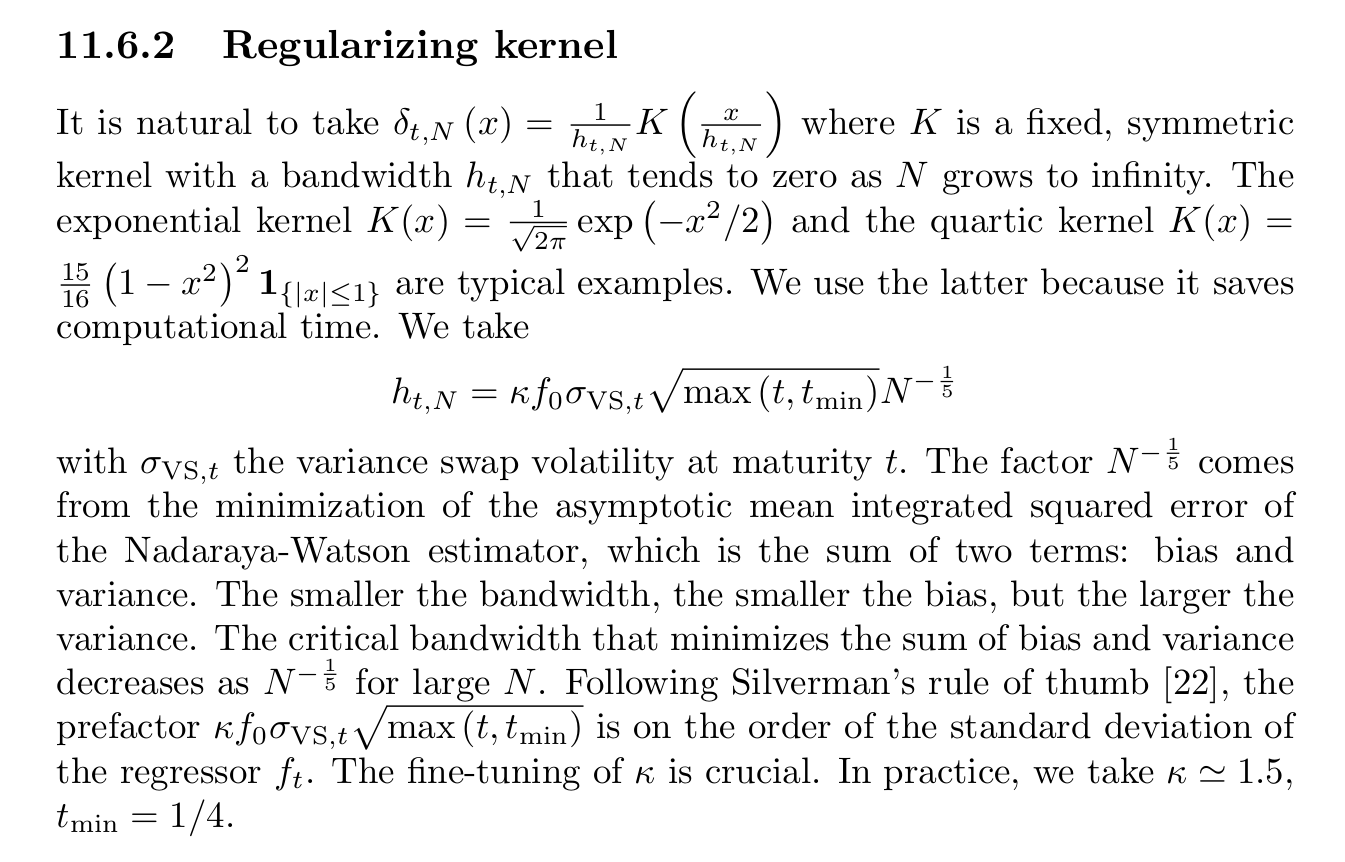

In [216]:
def pm_calibration(heston_parameters: HestonParameters,
                   state: MarketState,
                   options: CallStockOption,
                   option_prices: np.ndarray,
                   hpar: PMParameters):
    """Calibrates local-stochastic volatiliy model to observed market prices
    assuming that the stochastic volatility part is already calibrated.
            
    Args: 
        heston_params (HestonParameters): the parameters of the Heston model, 
            that are assumed to be calibrated to observed prices.
        state (MarketState): the current observed state of the market.
        options (CallStockOption): grid of call options, which prices are observed.
        oprion_prices (np.ndarray): 2d array (time to expiration × strike price)
            of that call options prices.
        hpar: parameters of Monte Carlo procedure (number of paths and steps)
    """
       
    dup_lv = make_local_vol_func(options, option_prices, state.interest_rate)

    # Monte Carlo simulation
    np.random.seed(5)
    S = np.empty([hpar.n_particles, hpar.n_steps + 1])
    V = np.empty([hpar.n_particles, hpar.n_steps + 1])
    
    r = state.interest_rate
    S[:, 0] = state.stock_price
    V[:, 0] = heston_parameters.v0
    time, dt = np.linspace(0, 
                           np.max(options.expiration_time), 
                           hpar.n_steps + 1, 
                           retstep=True)
     
    def kernel_f(x, t, sigma):
        scaling_factor = (
            hpar.kernel_scaling_factor 
            * state.stock_price
            * sigma * np.sqrt(np.maximum(t, hpar.kernel_t_min))
            / np.power(hpar.n_particles, .2)
        )
        return (
            15 / 16 / scaling_factor
            * (1 - np.clip(x / scaling_factor, -1, 1) ** 2) ** 2
        )
        
        
    # sigma = lambda t, s: dup_lv(0, s) / hpar.grid_range_proba
    sigma = 1.0
    leverage_func = np.empty((len(options.strike_price), hpar.n_steps))
    for i in trange(1, hpar.n_steps + 1):
        
        # make a step forward using Euler discretization scheme
        new_v = cir_chi_sq_sample(heston_parameters, dt, V[:, i-1], hpar.n_particles)
        V[:, i] = new_v
        # logS[:, ind + 1] = logS[:, ind] + (r - V[:, ind] / 2) * dt + \
                   # (rho / gamma) * (V[:, ind + 1] - V[:, ind] - kappa * (vbar - V[:, ind]) * dt) + \
                   # np.power((1 - rho**2) * dt * V[:, ind], 0.5) * Z1[:, ind] 
        d_log_s = (
            (r - 0.5 * sigma**2 * V[:, i-1]) * dt
            + heston_parameters.rho / heston_parameters.gamma * sigma * (
                new_v - heston_parameters.kappa * heston_parameters.vbar * dt + V[:, i-1] * (heston_parameters.kappa * dt - 1)
            )
            + np.random.normal(size=hpar.n_particles) * np.sqrt(1 - heston_parameters.rho**2) * sigma * np.sqrt(V[:, i-1] * dt)
        )
        new_s = np.exp(np.log(S[:, i-1]) + d_log_s)
        S[:, i] = new_s
        
        new_s = np.sort(new_s)
        idx = int(hpar.grid_range_proba * hpar.n_particles)
        # grid_span = (new_s[idx], new_s[-idx])
        
        # compute leverage function at gtid points
        # s_eval = np.linspace(*grid_span, hpar.n_interp)
        s_eval = new_s[idx:-idx:int(hpar.n_particles / hpar.n_interp)]
        kernels = kernel_f(s_eval[:, None] - new_s[None, :], time[i], np.sqrt(new_v[None, :]))
        kernels = np.where(kernels > np.quantile(kernels, .99, axis=1, keepdims=True), kernels, 0)
        expected_var = np.maximum(kernels @ new_v / kernels.sum(axis=1), 1e-12)
        sigma_eval = (dup_lv(time[i], s_eval) / np.sqrt(expected_var)).squeeze()
        sigma_f = interp1d(s_eval, 
                           sigma_eval, 
                           kind='cubic',
                           assume_sorted=True,
                           bounds_error=False,
                           fill_value=(sigma_eval[0], sigma_eval[-1]))
        sigma = sigma_f(new_s)
        leverage_func[:, i - 1] = sigma_f(options.strike_price)
        
    return S, leverage_func

In [195]:
N_STRIKES = 40
N_TIMES = 40

state = MarketState(stock_price = 100, interest_rate = 0.06, dividends_rate = 0)
market_heston_params = HestonParameters(kappa=1.0,
                                        gamma=0.4,
                                        rho=-0.6,
                                        vbar=0.2,
                                        v0=0.2)
options = CallStockOption(strike_price=np.linspace(40, 250, N_STRIKES),
                          expiration_time=np.sum(np.linspace(0, 1, N_TIMES, endpoint=False, retstep=True)))
option_prices = np.empty((N_TIMES, N_STRIKES))
for i, t in enumerate(options.expiration_time):
    option_prices[i] = OptionPriceWithCosMethodHelp(
        options.is_call,
        t,
        options.strike_price,
        state,
        market_heston_params,
        500, 8).squeeze()

Text(0.5, 0, 'Option price, $')

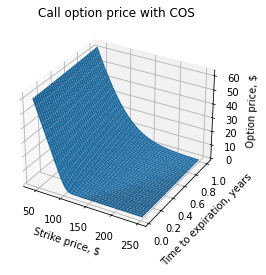

In [196]:
fig = plt.figure()
x, y = np.meshgrid(options.strike_price, options.expiration_time)

ax1 = fig.add_subplot(projection='3d')
ax1.plot_surface(x, y, option_prices)
ax1.set_title('Call option price with COS')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

In [217]:
heston_parameters = HestonParameters(kappa = 1.3, gamma = 0.3, rho = -0.3, vbar = 0.2, v0 = 0.2)
hpar = PMParameters(
    n_particles=10000,
    n_steps=500,
    kernel_scaling_factor=1.5,
    kernel_t_min=0.25,
    n_interp=100
) 

S, leverage_func = pm_calibration(market_heston_params, state, options, option_prices, hpar)

  0%|          | 0/500 [00:00<?, ?it/s]

[0.44625437 0.43907053 0.4372309  0.43540399 0.43420952 0.43335907
 0.43277714 0.4318479  0.43179802 0.43181929 0.43147352 0.43143658
 0.43135389 0.43120724 0.43117081 0.430869   0.43071068 0.43087817
 0.4307659  0.43103546 0.43101069 0.43099543 0.43058286 0.43047775
 0.43043544 0.43055643 0.43045481 0.4302847  0.43033949 0.43027792
 0.43027766 0.42996895 0.42998296 0.42971407 0.42942314 0.42959099
 0.42953245 0.42934848 0.42938408 0.42922631 0.42919543 0.42926479
 0.4290869  0.4290398  0.42924201 0.42927181 0.42904417 0.42896925
 0.4290944  0.4289753  0.42880994 0.42863796 0.42859402 0.42883647
 0.42882366 0.42881172 0.42874646 0.42885983 0.42881652 0.4288112
 0.42873776 0.42832745 0.42816992 0.42814863 0.42815412 0.42834798
 0.42846952 0.42850196 0.4285688  0.42860662 0.4287376  0.42889851
 0.42898254 0.42873982 0.42883027 0.42925392 0.42954232 0.4294884
 0.42949948 0.429646   0.43007554 0.43028919 0.43027061 0.43060158
 0.43078792 0.43109953 0.4313032  0.43136167 0.43138746 0.431827

KeyboardInterrupt: 

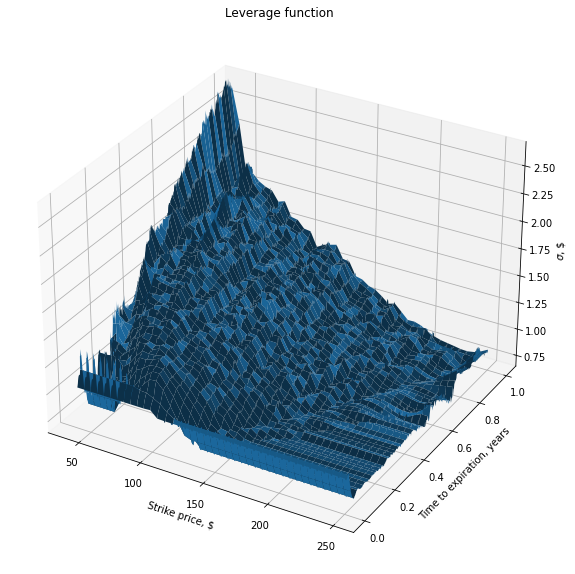

In [212]:
fig = plt.figure(figsize=(10, 10))
x, y = np.meshgrid(options.strike_price, np.linspace(0, 1, hpar.n_steps), indexing="ij")

ax1 = fig.add_subplot(projection='3d')
ax1.plot_surface(x, y, leverage_func)
ax1.set_title('Leverage function')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('$\sigma$, \$')
ax1.set_zlim((np.quantile(leverage_func, .001),
              np.quantile(leverage_func, .999)))
plt.show()

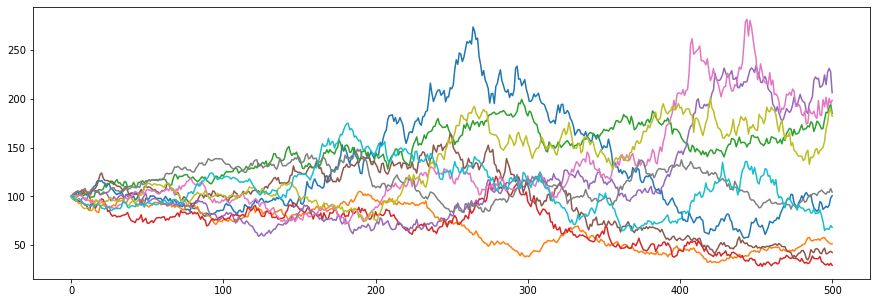

In [189]:
_, ax = plt.subplots(figsize=(15, 5))
ax.plot(S[:10].T)
plt.show()

In [213]:
ret = (S[:, -1] - S[:, 0]) / S[:, 0]

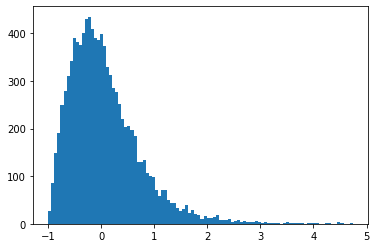

In [214]:
_, ax = plt.subplots()
# ax.hist(S[:, -1], bins=30)
ax.hist(ret, bins=100)
plt.show()

In [204]:
np.mean(S[:, -1]), np.std(S[:, -1])

(106.57988076834408, 67.32223697146773)

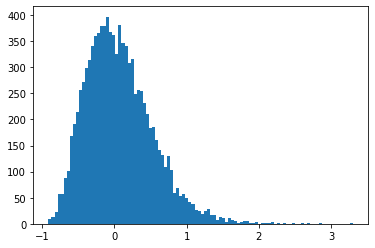

In [215]:
res = simulate_paths_heston_andersen(np.linspace(0, 1, 500),
                                     n_simulations=10000,
                                     state=state,
                                     heston_params=market_heston_params)
S_gt = res["asset"]
ret_gt = (S_gt[:, -1] - S_gt[:, 0]) / S_gt[:, 0]
_, ax = plt.subplots()
# ax.hist(S_gt[:, -1], bins=100)
ax.hist(ret_gt, bins=100)
plt.show()

In [211]:
np.mean(S_gt[:, -1]), np.std(S_gt[:, -1])

(106.54847529774982, 46.01456454912854)